# Functional API

The functional API is more flexible than the Sequential API. It can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

In [1]:
# Import the libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Let's build our first model using the functional api.
# A Deep Learning model can be seen like a DAG.

# First, we set the inputs
inputs = keras.Input(shape=(784,))  # here we are omitting the batch size

print(inputs.shape)
print(inputs.dtype)


(None, 784)
<dtype: 'float32'>


In [3]:
# Let's create a new node on the graph
dense = layers.Dense(64, activation="relu")
x = dense(inputs)  # this is like drawing a row between inputs & the new node

In [4]:
# Some more nodes
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)


In [5]:
# At this point, we can create a model by specifying the inputs and
# outputs in the graph
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


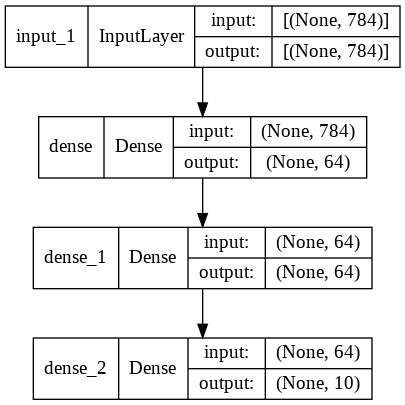

In [7]:
# You can also plot the graph
keras.utils.plot_model(model, "my_first_model.png", show_shapes=True)

## Training, evaluation and inference

These operations works in the same way as using the Sequential API.

In [12]:
# Let's see a training + evaluation example using MNIST

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# The images (x_train and x_test) has a shape of: [set_size, width, height]
# Here we are reshaping them to a 28*280=784 vector, converting them to float
# and normalizing them
num_training_imgs, width, height = x_train.shape
num_test_imgs, width, height = x_test.shape
x_train = x_train.reshape(num_training_imgs, width*height).astype("float32") / 255.0
x_test = x_test.reshape(num_test_imgs, width*height).astype("float32") / 255.0

# Now compile the previous defined model
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=keras.optimizers.RMSprop(),
             metrics=["accuracy"])

# Train the model for 2 epochs. We will use 20% of the data as validation.
history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

# Finally, evaluate the model on the test set
test_scores = model.evaluate(x_test, y_test, verbose=2)
print(f"Test loss: {test_scores[0]}")
print(f"Test acc: {test_scores[1]}")

Epoch 1/2
750/750 [==============================] - 3s 3ms/step - loss: 0.3474 - accuracy: 0.9017 - val_loss: 0.2017 - val_accuracy: 0.9402
Epoch 2/2
750/750 [==============================] - 2s 3ms/step - loss: 0.1652 - accuracy: 0.9511 - val_loss: 0.1371 - val_accuracy: 0.9599
313/313 - 0s - loss: 0.1313 - accuracy: 0.9608 - 353ms/epoch - 1ms/step
Test loss: 0.13128089904785156
Test acc: 0.9607999920845032


## Save and serialize
Saving the model and serialization work the same way for models built using the functional API as they do for Sequential models.

The saved file includes:
- Model architecture
- Model weights
- Training config (passed to 'compile')
- Optimizer and its state

In [14]:
# Save and delete the model
model.save("my_model")
del model

# Reload the model
model = keras.models.load_model("my_model")
model.summary()

INFO:tensorflow:Assets written to: my_model/assets
Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


## Defining models using the same graph


In [15]:
# Let's build a graph that defines an encoder model: 
# it gets an image as input and converts it to 16-dimensional vectors

encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

# Create the model
encoder = keras.Model(inputs=encoder_input, outputs=encoder_output, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 32)          9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 16)          4624      
                                                           

In [16]:
# Now, using the same encoder, let's add a decoder to build an autoencoder.
# The decoding architecture is symmetrical to the encoding one.

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(inputs=encoder_input, outputs=decoder_output, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 32)          9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 16)          4624      
                                                       

## Models are callable


In [17]:
# Let's define again a encoder and a decoder, independently
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_img (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 32)          9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 16)          4624      
                                                           

In [18]:
# You can create the autoencoder by nesting the models. This is because the
# model is just like a layer.
autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)  # calls the encoder
decoded_img = decoder(encoded_img)  # calls the decoder
autoencoder = keras.Model(autoencoder_input, decoded_img, name=autoencoder)
autoencoder.summary()


Model: "<keras.engine.functional.Functional object at 0x7f30c552d690>"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                18672     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         9569      
                                                                 
Total params: 28,241
Trainable params: 28,241
Non-trainable params: 0
_________________________________________________________________


A common use case for model nesting is ensembling:

In [20]:
# Let's create a function that returns a simple model.
def get_model():
  inputs = keras.Input(shape=(128,))
  outputs = layers.Dense(1)(inputs)
  return keras.Model(inputs=inputs, outputs=outputs)

# Now, let's instanciate 3 of these models
model1 = get_model()
model2 = get_model()
model3 = get_model()

# A common use of ensembling is to make predictions with the 3 models
# in parallel and then average them
inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
ensemble_model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 model_3 (Functional)           (None, 1)            129         ['input_8[0][0]']                
                                                                                                  
 model_4 (Functional)           (None, 1)            129         ['input_8[0][0]']                
                                                                                                  
 model_5 (Functional)           (None, 1)            129         ['input_8[0][0]']                
                                                                                            

## Complex graph topologies

### Multiple inputs and outputs
This cannot be handled with the Sequential API.

Let's build a model for ranking customer issue tickets by priority and routing them to the correct department. It would have 3 inputs:
- Title (text)
- Body (text)
- Tags added (categorical)

This model would have 2 outputs:
- Priority score between 0 and 1.
- The department that should handle the tickt.

In [23]:
# Let's first define some variables:
num_tags = 12  # num of possible tags
num_words = 10000  # size of vocabulary
num_departments = 4  # number of departments

# Now, let's define the 3 inputs:
title_input = keras.Input(shape=(None,), name="title")  # variable length. sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # variable length
tags_input = keras.Input(shape=(num_tags,), name="tags")  # binary vector of tags

# Text inputs should be converted to embeddings:
title_features = layers.Embedding(num_words, 64)(title_input)
body_features = layers.Embedding(num_words, 64)(body_input) 

# Now, reduce the sequence of embedded words in the title into a 128-dimensional
# vector, and the text body to a 32-dimensional vector
title_features = layers.LSTM(128)(title_features)
body_features = layers.LSTM(32)(body_features)

# Now, concatenate all the available features into a single vector of 
#128+32+12=172 values
x = layers.concatenate([title_features, body_features, tags_input])

# Let's define the 2 outputs:
# 1. Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# 2. Stick a deparment classifier too
department_pred = layers.Dense(num_departments, name="department")(x)
# Note: here we are not setting the sigmoid and softmax functions yet.

# Finally, instantiate an end-to-end model with all the inputs and outputs
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred]
    )


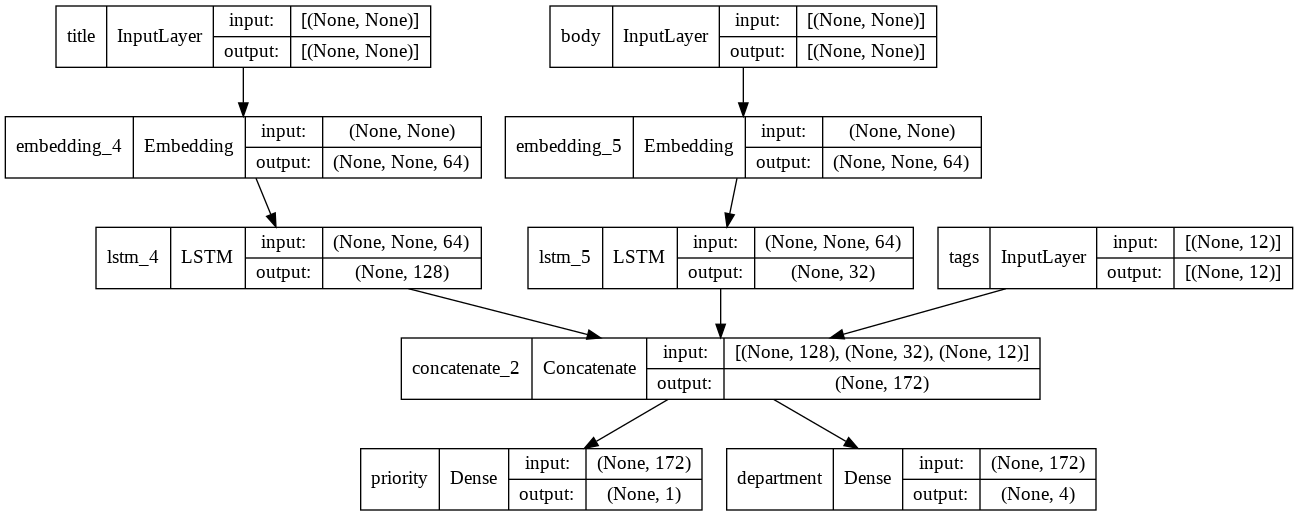

In [24]:
# Visualize the model
keras.utils.plot_model(model, "multi_input_output.png", show_shapes=True)

In [25]:
# Let0s train the model. You can use different losses to each output, and even
# assign different weights to modulate their contribution to the total training
# loss.
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
        loss = {
          "priority": keras.losses.BinaryCrossentropy(from_logits=True),
          "department": keras.losses.CategoricalCrossentropy(from_logits=True)
        },
        loss_weights = {"priority": 1.0, "department": 0.2}
)


In [26]:
# Now, let's train the model with some dummy inputs and targets:
import numpy as np

# Dummy inputs
dummy_title = np.random.randint(num_words, size=(1280, 10))  # batch size = 10
dummy_body = np.random.randint(num_words, size=(1280, 100))
dummy_tags = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy targets
dummy_priority = np.random.random(size=(1280, 1))
dummy_department = np.random.randint(2, size=(1280, num_departments))

# Train the model
model.fit(
    {"title": dummy_title, "body": dummy_body, "tags": dummy_tags},  # inputs
    {"priority": dummy_priority, "department": dummy_department},
    epochs=2,
    batch_size=32
)

Epoch 1/2
40/40 [==============================] - 6s 54ms/step - loss: 1.3186 - priority_loss: 0.7051 - department_loss: 3.0677
Epoch 2/2
40/40 [==============================] - 2s 57ms/step - loss: 1.3132 - priority_loss: 0.6993 - department_loss: 3.0697


### A toy ResNet model

The functional API makes it easy to manipulate non-linear connectivity topologies, like residual connections.

Let's build a toy ResNet:

In [27]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])  # residual connection

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])  # residual connection

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 30, 30, 32)   896         ['img[0][0]']                    
                                                                                                  
 conv2d_9 (Conv2D)              (None, 28, 28, 64)   18496       ['conv2d_8[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 9, 9, 64)    0           ['conv2d_9[0][0]']               
                                                                                         

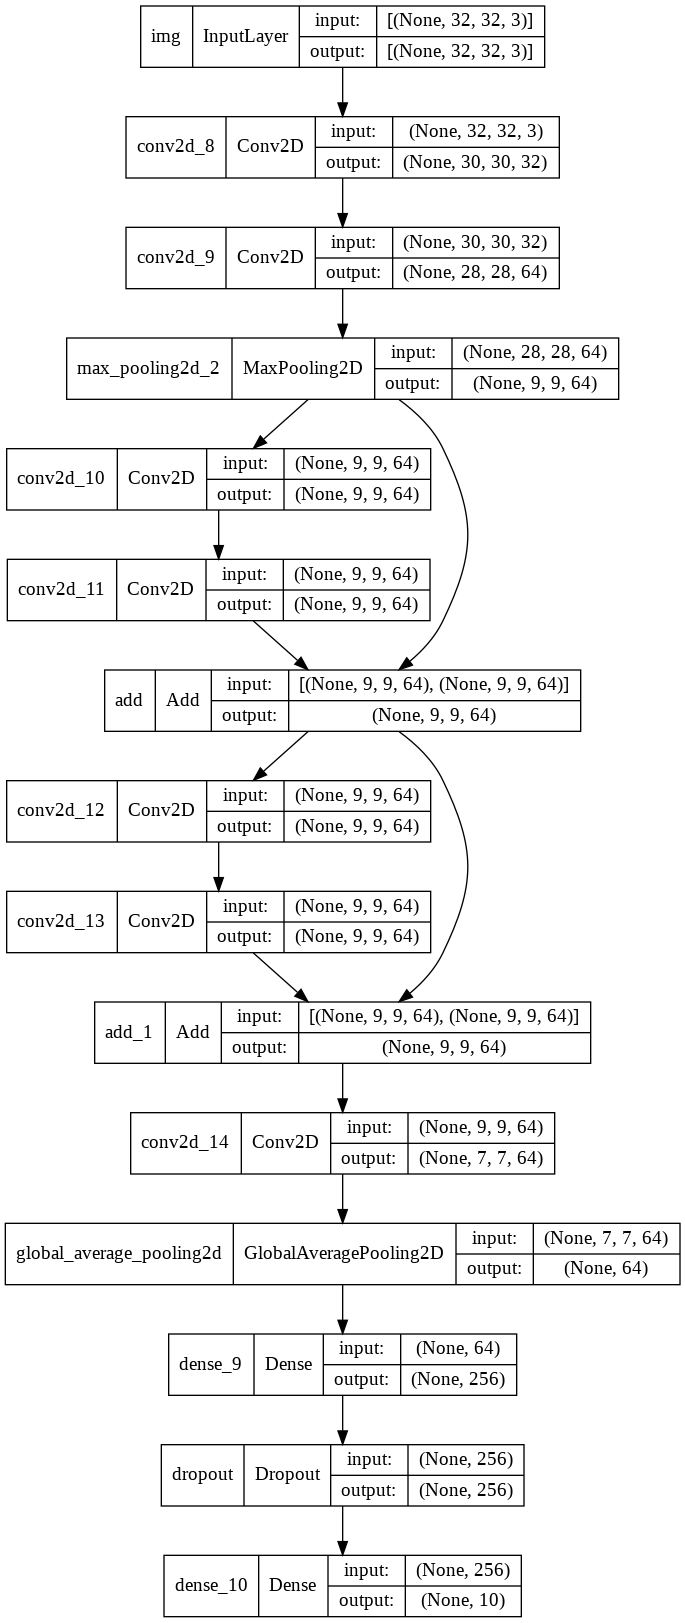

In [28]:
# Plot the model
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

In [31]:
# Let's train the model on CIFAR10

# Load the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize input images
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convert the target vectors to binary class matrix
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Compile the model
model.compile(
    loss = keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.RMSprop(learning_rate=1e-3),
    metrics=["acc"]
)

# Train the model
# We restrict the data to the first 1000 samples so as to limit execution time
# on Colab.
model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=64, validation_split=0.2)


13/13 [==============================] - 6s 348ms/step - loss: 2.3111 - acc: 0.0988 - val_loss: 2.2957 - val_acc: 0.1300


### Shared layers

Another good use for the functional API are models that use shared layers. Shared layers are layer instances that are reused multiple times in the same model (more info on: https://www.tensorflow.org/guide/keras/functional#shared_layers). 

In [33]:
# Let's define a shared embedding layer:

# First, we create the layer: 1000 unique words are mapped to 128-dimensional
# vectors.
shared_embedding = layers.Embedding(1000, 128)

# Let's now define 2 different inputs
text_input_a = keras.Input(shape=(None,), dtype="int32")
text_input_b = keras.Input(shape=(None,), dtype="int32")

# Encode both inputs with the same embedding layer
encoded_a = shared_embedding(text_input_a)
encoded_b = shared_embedding(text_input_b)

### Feature extraction using the Functional API

You can access the activations of intermediate layers ("nodes" in the graph) and reuse them elsewhere. This is useful for something like feature extraction.

In [34]:
# Let's load a VGG19 model with weights pretrained on ImageNet
vgg19 = tf.keras.applications.VGG19()

574726144/574710816 [==============================] - 6s 0us/step


In [35]:
# You can iterate through all the layers and store the intermediate activations
# in, for example, a list.
features_list = [layer.output for layer in vgg19.layers]

In [36]:
# You can use these features to define a feature-extraction model
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

In [37]:
# Let's use the model with a dummy input. Here we are simulating a 224x224 RGB
# normalized image:
img = np.random.random((1, 224, 224, 3)).astype("float32")

# Pass this image through the feature extractor
extracted_features = feat_extraction_model(img)
len(extracted_features)

26

### Creating custom layers

Apart from the built-in layers, you can define your own. 

All layers subclass the Layer class and implement:
- call method: what the layer does.
- build method: creates the weights of the layer.

In [45]:
# Let's implement a basic dense layer.

class CustomDense(layers.Layer):  # derived from the Layer class
  def __init__(self, units=32):
    super(CustomDense, self).__init__()
    self.units = units

  def build(self, input_shape):
    # Create the weights
    self.w = self.add_weight(
        shape=(input_shape[-1], self.units),
        initializer="random_normal",
        trainable=True,
    )

    # And the bias
    self.b = self.add_weight(
        shape=(self.units,),
        initializer="random_normal",
        trainable=True,
    )

  def call(self, inputs):
    outputs = tf.matmul(inputs, self.w) + self.b  # w*x + b
    return outputs

  def get_config(self):  # for serialization support.
    return {"units": self.units}  # return the constructor arguments

In [46]:
# Let's try our custom layer
inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)

In [47]:
# Let's create the model from the configuration
config = model.get_config()
new_model = keras.Model.from_config(config, custom_objects={"CustomDense": CustomDense})